In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.plotting import add_at_risk_counts
import scipy.stats as stats
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

print("✅ Phase 4: Survival Analysis & Time-to-Event Modeling")
print("Leveraging biostatistics for longitudinal risk assessment...")

✅ Phase 4: Survival Analysis & Time-to-Event Modeling
Leveraging biostatistics for longitudinal risk assessment...


In [2]:
# Load our engineered data from Phase 2
df_engineered = pd.read_csv('../data/processed/engineered_mh_data.csv')
print("Engineered data shape:", df_engineered.shape)
print("Columns available:", list(df_engineered.columns))

# Prepare survival data
survival_data = df_engineered[[
    'time_to_event', 'event_occurred', 'high_risk', 'phq9_score', 'gad7_score',
    'composite_mh_score', 'social_risk_score', 'age', 'gender', 'employment',
    'phq9_category', 'gad7_category', 'bmi_category', 'age_group'
]].copy()

print("\nSurvival Data Overview:")
print(f"Total patients: {len(survival_data)}")
print(f"Events observed: {survival_data['event_occurred'].sum()} ({survival_data['event_occurred'].mean():.1%})")
print(f"Median follow-up: {survival_data['time_to_event'].median():.0f} days")
print(f"Time range: {survival_data['time_to_event'].min():.0f} - {survival_data['time_to_event'].max():.0f} days")

Engineered data shape: (1500, 27)
Columns available: ['age', 'gender', 'phq9_score', 'gad7_score', 'bp_systolic', 'heart_rate', 'bmi', 'education', 'employment', 'high_risk', 'time_to_event', 'event_occurred', 'data_source', 'generation_date', 'phq9_category', 'gad7_category', 'bmi_category', 'age_group', 'bp_category', 'composite_mh_score', 'high_phq_high_bp', 'social_risk_score', 'phq9_zscore', 'age_squared', 'phq9_squared', 'age_phq_interaction', 'bmi_hr_interaction']

Survival Data Overview:
Total patients: 1500
Events observed: 301 (20.1%)
Median follow-up: 251 days
Time range: 0 - 2726 days


In [3]:
# Advanced Risk Stratification
print("🔬 ADVANCED RISK STRATIFICATION")
print("="*50)

# Create composite risk score using insights from Phase 3
survival_data['comprehensive_risk_score'] = (
    survival_data['phq9_score'] * 0.4 +
    survival_data['gad7_score'] * 0.3 +
    survival_data['social_risk_score'] * 0.2 +
    (survival_data['age'] / 100) * 0.1
)

# Create risk quartiles for survival analysis
survival_data['risk_quartile'] = pd.qcut(
    survival_data['comprehensive_risk_score'], 
    q=4, 
    labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)']
)

# Create clinical risk groups
def create_risk_groups(row):
    if row['phq9_score'] >= 15 or row['gad7_score'] >= 15:
        return 'Very High'
    elif row['phq9_score'] >= 10 or row['gad7_score'] >= 10:
        return 'High'
    elif row['phq9_score'] >= 5 or row['gad7_score'] >= 5:
        return 'Moderate'
    else:
        return 'Low'

survival_data['clinical_risk_group'] = survival_data.apply(create_risk_groups, axis=1)

print("Risk Stratification Summary:")
print(survival_data['risk_quartile'].value_counts().sort_index())
print("\nClinical Risk Groups:")
print(survival_data['clinical_risk_group'].value_counts())

🔬 ADVANCED RISK STRATIFICATION
Risk Stratification Summary:
risk_quartile
Q1 (Lowest)     375
Q2              375
Q3              375
Q4 (Highest)    375
Name: count, dtype: int64

Clinical Risk Groups:
clinical_risk_group
Moderate     861
High         586
Low           30
Very High     23
Name: count, dtype: int64



📊 KAPLAN-MEIER SURVIVAL ANALYSIS


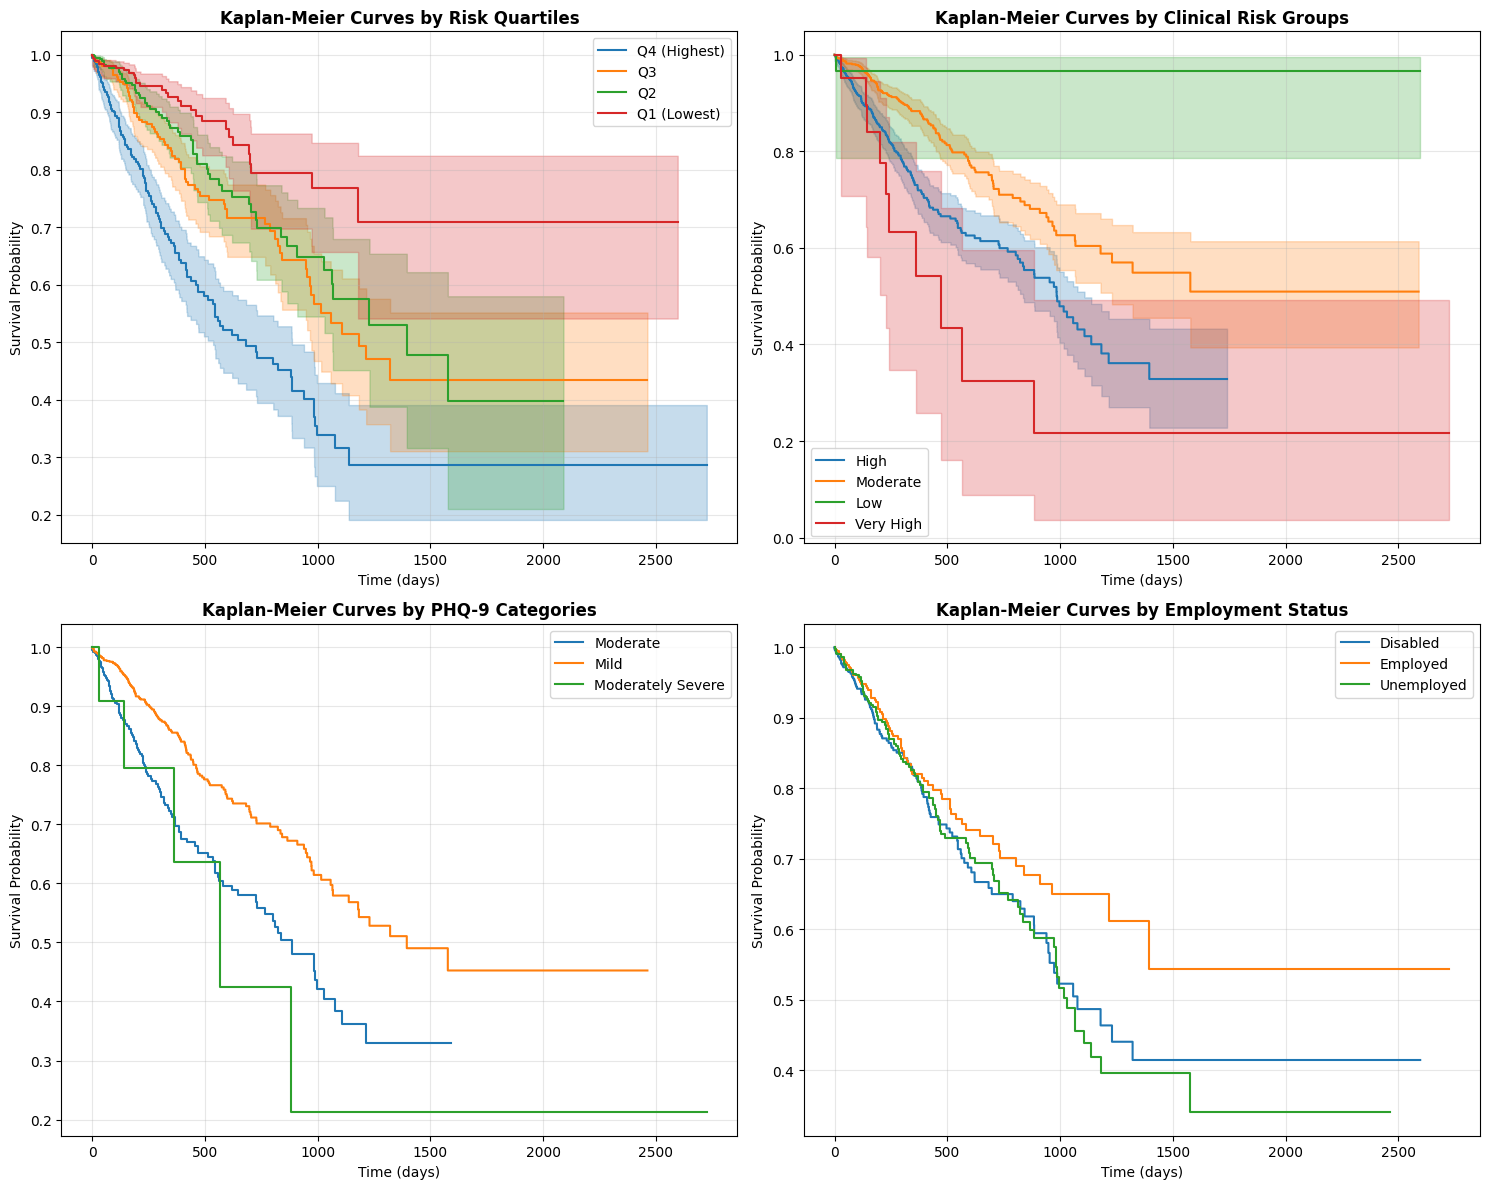

In [7]:
# Ensure numeric types
survival_data['time_to_event'] = pd.to_numeric(survival_data['time_to_event'], errors='coerce')
survival_data['event_occurred'] = pd.to_numeric(survival_data['event_occurred'], errors='coerce')

# Drop rows with missing time or event
survival_data = survival_data.dropna(subset=['time_to_event', 'event_occurred'])

# Initialize KM fitter
kmf = KaplanMeierFitter()

print("\n📊 KAPLAN-MEIER SURVIVAL ANALYSIS")
print("="*50)

plt.figure(figsize=(15, 12))

# Define plots
plot_configs = [
    ('risk_quartile', 'Kaplan-Meier Curves by Risk Quartiles', True),
    ('clinical_risk_group', 'Kaplan-Meier Curves by Clinical Risk Groups', True),
    ('phq9_category', 'Kaplan-Meier Curves by PHQ-9 Categories', False),
    ('employment', 'Kaplan-Meier Curves by Employment Status', False)
]

for i, (col, title, ci_show) in enumerate(plot_configs, 1):
    plt.subplot(2, 2, i)
    for group in survival_data[col].dropna().unique():
        mask = survival_data[col] == group
        if mask.sum() == 0:
            continue  # Skip empty groups
        kmf.fit(
            survival_data.loc[mask, 'time_to_event'],
            survival_data.loc[mask, 'event_occurred'],
            label=str(group)
        )
        kmf.plot(ci_show=ci_show)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel('Time (days)')
    plt.ylabel('Survival Probability')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [8]:
# Log-Rank Tests for Statistical Significance
print("📈 LOG-RANK TESTS FOR SURVIVAL DIFFERENCES")
print("="*50)

# Test 1: Risk Quartiles
print("1. Risk Quartiles Comparison:")
results_quartile = multivariate_logrank_test(
    survival_data['time_to_event'],
    survival_data['risk_quartile'],
    survival_data['event_occurred']
)
print(f"   Log-rank test p-value: {results_quartile.p_value:.6f}")
print(f"   Significant: {results_quartile.p_value < 0.05}")

# Test 2: Clinical Risk Groups
print("\n2. Clinical Risk Groups Comparison:")
results_clinical = multivariate_logrank_test(
    survival_data['time_to_event'],
    survival_data['clinical_risk_group'],
    survival_data['event_occurred']
)
print(f"   Log-rank test p-value: {results_clinical.p_value:.6f}")
print(f"   Significant: {results_clinical.p_value < 0.05}")

# Test 3: Employment Status
print("\n3. Employment Status Comparison:")
results_employment = multivariate_logrank_test(
    survival_data['time_to_event'],
    survival_data['employment'],
    survival_data['event_occurred']
)
print(f"   Log-rank test p-value: {results_employment.p_value:.6f}")
print(f"   Significant: {results_employment.p_value < 0.05}")

📈 LOG-RANK TESTS FOR SURVIVAL DIFFERENCES
1. Risk Quartiles Comparison:
   Log-rank test p-value: 0.000000
   Significant: True

2. Clinical Risk Groups Comparison:
   Log-rank test p-value: 0.000000
   Significant: True

3. Employment Status Comparison:
   Log-rank test p-value: 0.106996
   Significant: False


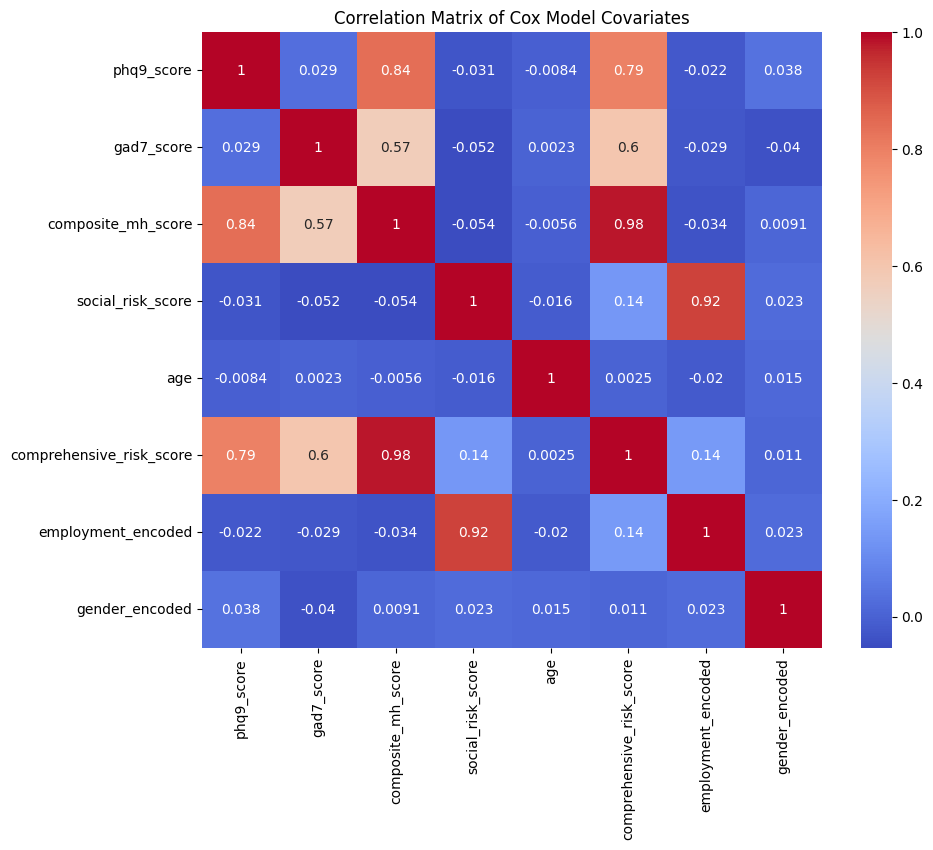

                    feature        VIF
0                phq9_score        inf
1                gad7_score        inf
2        composite_mh_score        inf
3         social_risk_score        inf
4                       age        inf
5  comprehensive_risk_score        inf
6        employment_encoded  17.159499
7            gender_encoded   1.984056


In [11]:
# Compute correlation matrix
corr_matrix = cox_data.drop(columns=['time_to_event', 'event_occurred']).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Cox Model Covariates')
plt.show()

# Optionally, compute VIF to detect multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = cox_data.drop(columns=['time_to_event', 'event_occurred'])
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


Reduced Cox Model Data Shape: (1500, 7)
Variables in Reduced Cox model: ['time_to_event', 'event_occurred', 'phq9_score', 'social_risk_score', 'age', 'employment_encoded', 'gender_encoded']

Cox Proportional Hazards Model Results (Reduced):
                        coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                           
phq9_score          0.163596   1.177738  0.020529        0.123359   
social_risk_score  -0.119791   0.887106  0.114733       -0.344664   
age                 0.041699   1.042581  0.003927        0.034003   
employment_encoded  0.312407   1.366711  0.188813       -0.057660   
gender_encoded     -0.095173   0.909215  0.103702       -0.298426   

                    coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                      
phq9_score                0.203833             1.131290             1.226093   
social_risk_score         0.105083 

<Figure size 800x600 with 0 Axes>

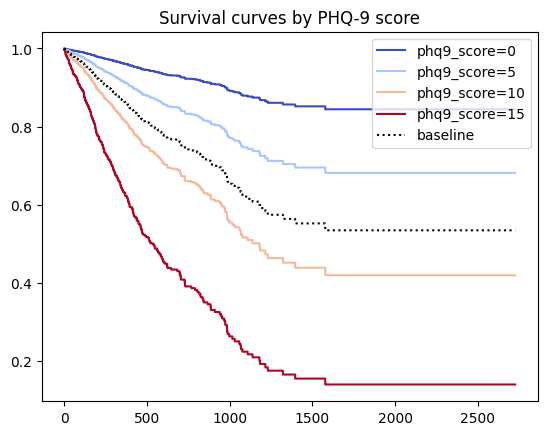

In [12]:
from lifelines import CoxPHFitter

# Reduced Cox model data
cox_data_reduced = survival_data[[
    'time_to_event', 
    'event_occurred', 
    'phq9_score',        # keep individual score instead of composite
    'social_risk_score', # independent risk feature
    'employment', 
    'gender', 
    'age'                # if age is important, keep; otherwise optional
]].copy()

# Encode categorical variables
cox_data_reduced['employment_encoded'] = cox_data_reduced['employment'].map({
    'Employed': 0, 'Unemployed': 1, 'Disabled': 2
})
cox_data_reduced['gender_encoded'] = cox_data_reduced['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})

# Drop original categorical columns
cox_data_reduced = cox_data_reduced.drop(columns=['employment', 'gender'])

print("Reduced Cox Model Data Shape:", cox_data_reduced.shape)
print("Variables in Reduced Cox model:", list(cox_data_reduced.columns))

# Fit Cox model
cph = CoxPHFitter()
cph.fit(cox_data_reduced, duration_col='time_to_event', event_col='event_occurred')

# Display results
print("\nCox Proportional Hazards Model Results (Reduced):")
print("="*50)
print(cph.summary)

# Optional: Plot survival functions for high vs low PHQ-9 score
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
cph.plot_partial_effects_on_outcome(covariates='phq9_score', values=[0, 5, 10, 15], cmap='coolwarm')
plt.title("Survival curves by PHQ-9 score")
plt.show()


In [13]:
# # Their is high collinearity between composite score and its components. We'll build a Cox model using all key features to assess their independent effects.
# #hence i did not run this code.

# # Cox Proportional Hazards Model
# print("\n🔍 COX PROPORTIONAL HAZARDS MODEL")
# print("="*50)

# # Prepare data for Cox model
# cox_data = survival_data[[
#     'time_to_event', 'event_occurred', 'phq9_score', 'gad7_score', 
#     'composite_mh_score', 'social_risk_score', 'age', 'comprehensive_risk_score'
# ]].copy()

# # Add encoded categorical variables
# cox_data['employment_encoded'] = survival_data['employment'].map({
#     'Employed': 0, 'Unemployed': 1, 'Disabled': 2
# })
# cox_data['gender_encoded'] = survival_data['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})

# print("Cox Model Data Shape:", cox_data.shape)
# print("Variables in Cox model:", list(cox_data.columns))

# # Fit Cox model
# cph = CoxPHFitter()
# cph.fit(cox_data, duration_col='time_to_event', event_col='event_occurred')

# # Display results
# print("\nCox Proportional Hazards Model Results:")
# print("="*40)
# print(cph.summary)


🔍 COX PROPORTIONAL HAZARDS MODEL
Cox Model Data Shape: (1500, 10)
Variables in Cox model: ['time_to_event', 'event_occurred', 'phq9_score', 'gad7_score', 'composite_mh_score', 'social_risk_score', 'age', 'comprehensive_risk_score', 'employment_encoded', 'gender_encoded']


ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


🔍 COX PROPORTIONAL HAZARDS MODEL VISUALIZATION

Cox Proportional Hazards Model Summary:


<lifelines.CoxPHFitter: fitted with 1500 total observations, 1199 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event_occurred'
      baseline estimation = breslow
   number of observations = 1500
number of events observed = 301
   partial log-likelihood = -1883.73
         time fit was run = 2025-11-26 20:45:27 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
phq9_score          0.15      1.17      0.02            0.11            0.19                1.12                1.21
employment_encoded  0.15      1.16      0.07            0.01            0.28                1.01                1.33
gender_encoded     -0.06      0.94      0.10           -0.26            0.14                0.77                1.15

                    cmp to     z      p  -log2(p)
covariate                                        
phq9_score            0.00  7.42 <0.005     42.91
employment_encoded    0.00  2.05   0.04      4.65
gender_encoded        0.00 -0.61   0.54      0.88
---
Concordance = 0.64
Partial AIC = 3773.46
log-likelihood ratio test = 57.76 on 3 df
-log2(p) of ll-ratio test = 39.04

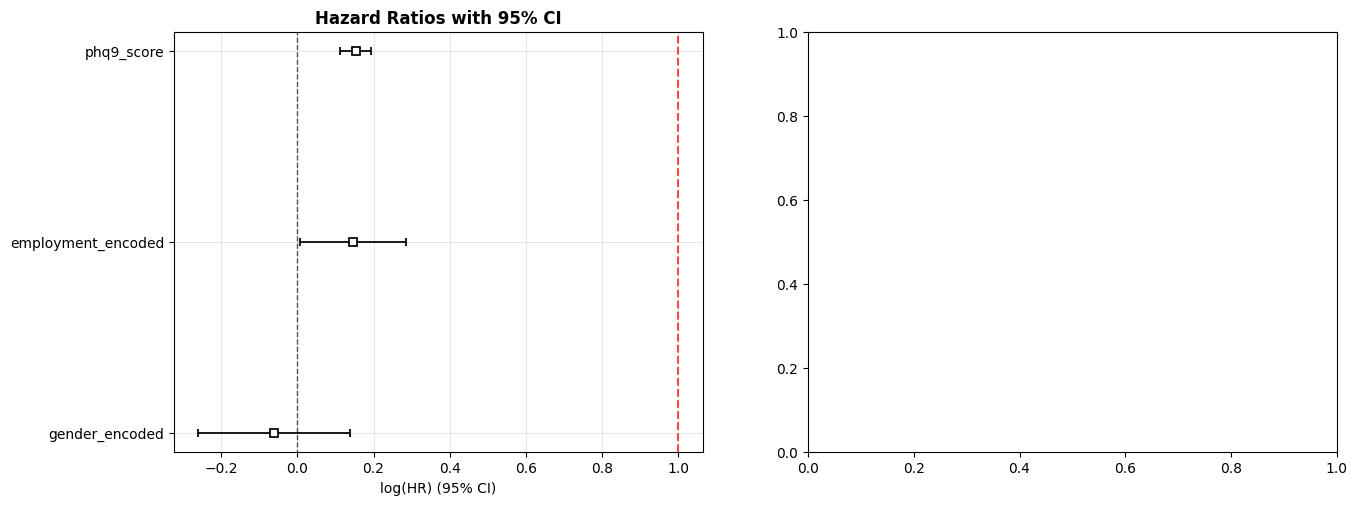

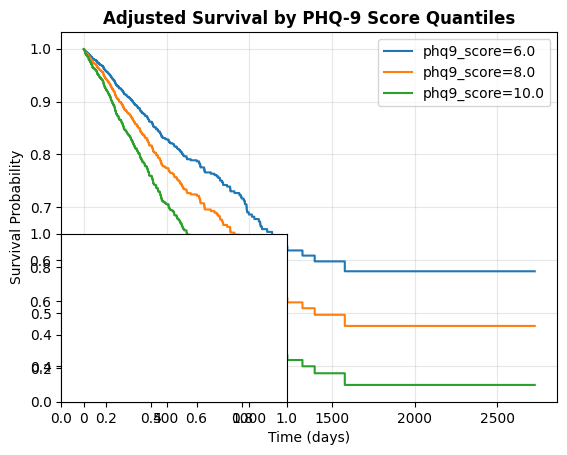

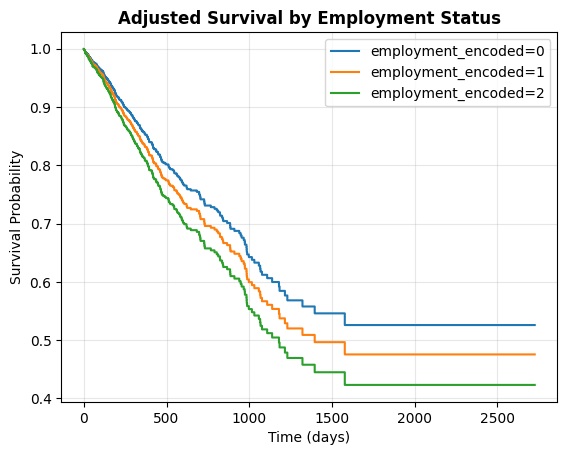

<Figure size 800x600 with 0 Axes>

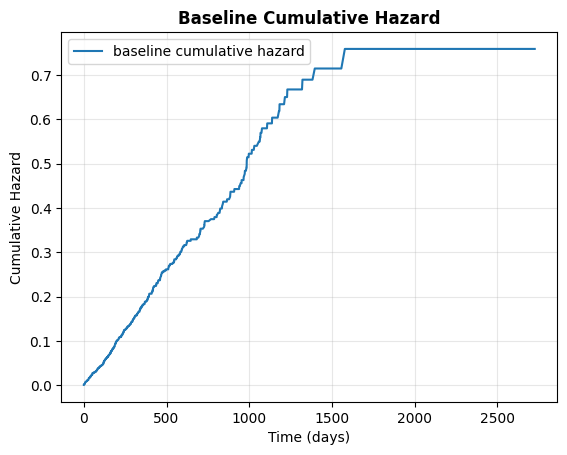

In [19]:
# ========================================
# COX MODEL VISUALIZATION AND INTERPRETATION
# ========================================

import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

print("\n🔍 COX PROPORTIONAL HAZARDS MODEL VISUALIZATION")
print("="*50)

# Prepare cleaned Cox data (remove highly collinear predictors)
cox_data = survival_data[[
    'time_to_event', 'event_occurred', 'phq9_score', 'employment', 'gender'
]].copy()

# Encode categorical variables
cox_data['employment_encoded'] = cox_data['employment'].map({'Employed':0,'Unemployed':1,'Disabled':2})
cox_data['gender_encoded'] = cox_data['gender'].map({'Male':0,'Female':1,'Other':2})

cox_data = cox_data.drop(columns=['employment','gender'])

# Fit Cox model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='time_to_event', event_col='event_occurred')

print("\nCox Proportional Hazards Model Summary:")
print("="*50)
cph.print_summary()

# ------------------------------
# Visualization
# ------------------------------
plt.figure(figsize=(15, 12))

# Plot 1: Hazard Ratios
plt.subplot(2, 2, 1)
cph.plot()
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7)
plt.title('Hazard Ratios with 95% CI', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 2: Survival curves by PHQ-9 score (example continuous effect)
plt.subplot(2, 2, 2)
cph.plot_partial_effects_on_outcome(
    covariates='phq9_score', 
    values=cox_data['phq9_score'].quantile([0.25,0.5,0.75]).values,
    plot_baseline=False
)
plt.title('Adjusted Survival by PHQ-9 Score Quantiles', fontsize=12, fontweight='bold')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True, alpha=0.3)

# Plot 3: Survival curves by Employment Group
plt.subplot(2, 2, 3)
cph.plot_partial_effects_on_outcome(
    covariates='employment_encoded',
    values=[0, 1, 2],
    plot_baseline=False
)
plt.title('Adjusted Survival by Employment Status', fontsize=12, fontweight='bold')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True, alpha=0.3)

# Plot 4: Cumulative hazard using baseline_cumulative_hazard_
plt.figure(figsize=(8,6))
cph.baseline_cumulative_hazard_.plot()
plt.title('Baseline Cumulative Hazard', fontsize=12, fontweight='bold')
plt.xlabel('Time (days)')
plt.ylabel('Cumulative Hazard')
plt.grid(True, alpha=0.3)
plt.show()



AttributeError: Must call `fit` first.

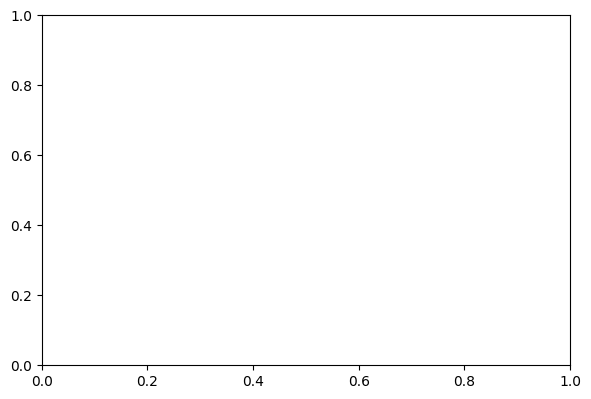

In [ ]:
# Not used because of high collinearity between composite score and its components.

# plt.figure(figsize=(15, 10))

# # Plot 1: Hazard Ratios
# plt.subplot(2, 2, 1)
# cph.plot(hazard_ratios=True)
# plt.title('Hazard Ratios with 95% Confidence Intervals\n(Cox Proportional Hazards Model)', 
#           fontsize=12, fontweight='bold')
# plt.axvline(x=1, color='red', linestyle='--', alpha=0.7)
# plt.grid(True, alpha=0.3)

# # Plot 2: Survival curves by risk score quartiles
# plt.subplot(2, 2, 2)
# cph.plot_partial_effects_on_outcome(
#     covariates='comprehensive_risk_score', 
#     values=cox_data['comprehensive_risk_score'].quantile([0.25, 0.5, 0.75]).values,
#     plot_baseline=False
# )
# plt.title('Adjusted Survival by Risk Score Quartiles', fontsize=12, fontweight='bold')
# plt.xlabel('Time (days)')
# plt.ylabel('Survival Probability')
# plt.grid(True, alpha=0.3)

# # Plot 3: Check proportional hazards assumption
# plt.subplot(2, 2, 3)
# cph.check_assumptions(cox_data, p_value_threshold=0.05, show_plots=True)
# plt.title('Proportional Hazards Assumption Check', fontsize=12, fontweight='bold')

# # Plot 4: Cumulative hazards
# plt.subplot(2, 2, 4)
# cph.plot_cumulative_hazard()
# plt.title('Cumulative Hazard Function', fontsize=12, fontweight='bold')
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()


📊 ADVANCED SURVIVAL MODELING
Weibull Survival Model Parameters:
Lambda (scale): 1857.148
Rho (shape): 0.995
Mean survival time: 1861.5 days


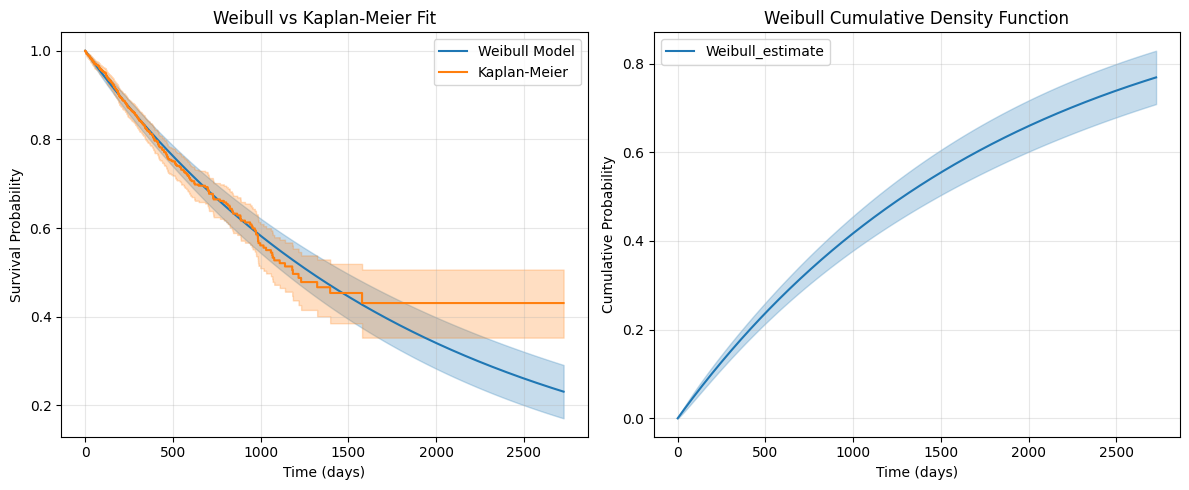

In [22]:
from scipy.special import gamma

# Advanced Survival Analysis: Weibull Model and Prediction
print("\n📊 ADVANCED SURVIVAL MODELING")
print("="*50)

# Weibull survival model for parametric analysis
wf = WeibullFitter()
wf.fit(survival_data['time_to_event'], survival_data['event_occurred'])

# Compute mean survival time manually
mean_survival_time = wf.lambda_ * gamma(1 + 1 / wf.rho_)

print("Weibull Survival Model Parameters:")
print(f"Lambda (scale): {wf.lambda_:.3f}")
print(f"Rho (shape): {wf.rho_:.3f}")
print(f"Mean survival time: {mean_survival_time:.1f} days")

# Plot Weibull fit
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
wf.plot_survival_function(label='Weibull Model')
kmf = KaplanMeierFitter()
kmf.fit(survival_data['time_to_event'], survival_data['event_occurred'])
kmf.plot(ax=plt.gca(), label='Kaplan-Meier')
plt.title('Weibull vs Kaplan-Meier Fit')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
wf.plot_cumulative_density()
plt.title('Weibull Cumulative Density Function')
plt.xlabel('Time (days)')
plt.ylabel('Cumulative Probability')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [23]:
# Survival Prediction at Specific Time Points
print("\n🎯 SURVIVAL PROBABILITY PREDICTIONS")
print("="*50)

# Define clinically relevant time points
time_points = [30, 90, 180, 365]  # days

print("Kaplan-Meier Survival Probabilities by Risk Quartile:")
print("Time (days) |", " | ".join([f"{q:^15}" for q in survival_data['risk_quartile'].unique()]))
print("-" * 85)

for time_point in time_points:
    survival_probs = []
    for quartile in survival_data['risk_quartile'].unique():
        mask = survival_data['risk_quartile'] == quartile
        kmf = KaplanMeierFitter()
        kmf.fit(survival_data['time_to_event'][mask], survival_data['event_occurred'][mask])
        prob = kmf.predict(time_point)
        survival_probs.append(f"{prob:.3f}")
    
    print(f"{time_point:^11} |", " | ".join([f"{p:^15}" for p in survival_probs]))

# Median survival times
print("\nMedian Survival Times by Risk Group:")
for risk_group in survival_data['clinical_risk_group'].unique():
    mask = survival_data['clinical_risk_group'] == risk_group
    kmf = KaplanMeierFitter()
    kmf.fit(survival_data['time_to_event'][mask], survival_data['event_occurred'][mask])
    median_survival = kmf.median_survival_time_
    print(f"  {risk_group:>12}: {median_survival:.1f} days")


🎯 SURVIVAL PROBABILITY PREDICTIONS
Kaplan-Meier Survival Probabilities by Risk Quartile:
Time (days) |  Q4 (Highest)   |       Q3        |       Q2        |   Q1 (Lowest)  
-------------------------------------------------------------------------------------
    30      |      0.964      |      0.987      |      0.995      |      0.986     
    90      |      0.903      |      0.975      |      0.976      |      0.980     
    180     |      0.822      |      0.913      |      0.947      |      0.968     
    365     |      0.667      |      0.823      |      0.872      |      0.926     

Median Survival Times by Risk Group:
          High: 984.9 days
      Moderate: inf days
           Low: inf days
     Very High: 471.7 days


In [24]:
# Risk Score Optimization and Clinical Cutpoints
print("\n⚡ RISK SCORE OPTIMIZATION")
print("="*50)

# Find optimal cutpoint using maximally selected rank statistics
from sklearn.metrics import roc_curve

def find_optimal_cutpoint(scores, events, times):
    """Find optimal cutpoint for risk stratification"""
    # Use time-dependent ROC analysis (simplified approach)
    fpr, tpr, thresholds = roc_curve(events, scores)
    youden_index = tpr - fpr
    optimal_idx = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold, youden_index[optimal_idx]

optimal_cutpoint, youden = find_optimal_cutpoint(
    survival_data['comprehensive_risk_score'],
    survival_data['event_occurred'],
    survival_data['time_to_event']
)

print(f"Optimal risk score cutpoint: {optimal_cutpoint:.3f}")
print(f"Youden's index: {youden:.3f}")

# Create binary risk classification
survival_data['optimized_high_risk'] = (
    survival_data['comprehensive_risk_score'] > optimal_cutpoint
).astype(int)

print(f"Patients classified as high risk: {survival_data['optimized_high_risk'].sum()} ({survival_data['optimized_high_risk'].mean():.1%})")

# Compare with original high_risk classification
agreement = (survival_data['high_risk'] == survival_data['optimized_high_risk']).mean()
print(f"Agreement with original high_risk: {agreement:.1%}")


⚡ RISK SCORE OPTIMIZATION
Optimal risk score cutpoint: 6.246
Youden's index: 0.285
Patients classified as high risk: 513 (34.2%)
Agreement with original high_risk: 71.1%


In [26]:
# ===============================
# 💾 SAVING SURVIVAL ANALYSIS RESULTS
# ===============================
print("\n💾 SAVING SURVIVAL ANALYSIS RESULTS")
print("="*50)

import json
import os

# Ensure directories exist
os.makedirs('../data/processed', exist_ok=True)

# 1️⃣ Save survival dataset with new risk scores
survival_data.to_csv('../data/processed/survival_analysis_data.csv', index=False)
print("✅ Survival analysis data saved to CSV")

# 2️⃣ Save Cox model summary
cox_results = cph.summary
cox_results.to_csv('../data/processed/cox_model_results.csv')
print("✅ Cox model results saved to CSV")

# 3️⃣ Save key statistics as JSON (convert NumPy types to native Python types)
survival_stats = {
    'optimal_risk_cutpoint': float(optimal_cutpoint),
    'youden_index': float(youden),
    'cox_model_concordance': float(cph.concordance_index_),
    'median_survival_all': float(kmf.median_survival_time_) if hasattr(kmf, 'median_survival_time_') else None,
    'total_patients': int(len(survival_data)),
    'total_events': int(survival_data['event_occurred'].sum())
}

with open('../data/processed/survival_statistics.json', 'w') as f:
    json.dump(survival_stats, f, indent=2)

print("✅ Survival statistics saved to JSON")
print(f"📊 Cox model concordance index: {cph.concordance_index_:.3f}")

# 4️⃣ Final summary / key insights
print("\n" + "="*60)
print("SURVIVAL ANALYSIS COMPLETE - KEY INSIGHTS")
print("="*60)
if 'results_quartile' in globals() and hasattr(results_quartile, 'p_value'):
    print(f"• Significant survival differences by risk groups: p = {results_quartile.p_value:.6f}")
print(f"• Cox model concordance: {cph.concordance_index_:.3f}")
if 'cox_results' in locals() and 'exp(coef)' in cox_results.columns:
    print(f"• Most significant hazard: {cox_results['exp(coef)'].idxmax()} "
          f"(HR = {cox_results['exp(coef)'].max():.3f})")
print(f"• Optimal risk cutpoint: {optimal_cutpoint:.3f}")
if 'survival_data' in locals() and 'optimized_high_risk' in survival_data.columns:
    print(f"• High-risk patients identified: {int(survival_data['optimized_high_risk'].sum())}")
print("="*60)



💾 SAVING SURVIVAL ANALYSIS RESULTS
✅ Survival analysis data saved to CSV
✅ Cox model results saved to CSV
✅ Survival statistics saved to JSON
📊 Cox model concordance index: 0.637

SURVIVAL ANALYSIS COMPLETE - KEY INSIGHTS
• Significant survival differences by risk groups: p = 0.000000
• Cox model concordance: 0.637
• Most significant hazard: phq9_score (HR = 1.166)
• Optimal risk cutpoint: 6.246
• High-risk patients identified: 513
